# **AutoID**
### Identifying Consumer Demographic Groups Via Facial Images
by Kevin Atkinson

## Business Understanding
Two of the major factors in advertising products to consumers are age and gender. While there are many factors in ascertaining the most optimal product advertisements to serve to an individual, these two to encompass a large portion of the equation. In this project we will attempt to use images of individuals to classify their age and gender to better target ads to individuals. 

For many market segments, the subsets of customers who shop online vs in-store may vary significantly. The demogrpahics of customers who enter a retail location is highly valuable information. Using this information could help optimize highly valuable, highly limited shelf space. It can serve to inform decisions regarding end-cap and floor displays. It can also be used to serve targeted ads directly to consumers as they browse shelves for products. 

One such application for this technology would be a cosmetics retail store such as an Ulta or Sephora, where the age group highly influences purchasing decisions. 

Implementing this technology can serve to optimize advertising dollars, retail shelf space, as well as enable more granular inventory selection from location to location.

## Data Understanding

Our data is being sourced from the [B3FD](https://github.com/kbesenic/B3FD) dataset. B3FD stands for Biometrically Filtered Famous Figure Dataset. Introduced in the paper [Picking out the bad apples: unsupervised biometric data ﬁltering forreﬁned age estimation](https://link.springer.com/epdf/10.1007/s00371-021-02323-y?sharing_token=z1NicVj4Fy7P340TvNARsPe4RwlQNchNByi7wbcMAY6I9f3BJkfEnl_nOTlEIb8Wo61IlQRlpMJvoIBvErNdzQVjHI_iw8GtkfEtU2GkEZUAH1OPj6rD6vzQM6L0QxHaTNktc-rMcuc7CpaKb-DYU5QZuxSyGKUtAzk9EUTpuwo=), the data consists of over 375,000 images of famous individuals derived from the [IMDB-WIKI](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/) and [CACD](https://bcsiriuschen.github.io/CARC/) datasets. The subjects of the images are 53,759 unique individuals, ranging in age from 0 to 101 years old.

We will be using subsets that have the classification targets of Age and Gender. This is because these are the minimum viable details in order to have reasonably successful targeted advertising. These images have been pre-aligned, and cropped to contain 50% context, as well as resized to be 256x256. You can download the dataset here: images: [B3FD_images.tar.gz](https://ferhr-my.sharepoint.com/:u:/g/personal/kbr122017_fer_hr/EU4lr6xf_ZhBi9vN_i8h_XEByhasE-qqKlcC7iqk5K9XtQ?e=Yox63W), metadata: [B3FD_metadata.tar.gz](https://ferhr-my.sharepoint.com/:u:/g/personal/kbr122017_fer_hr/EcKiZtbTTb5Ep-fN32wCx4oBIcY64Wr8JhxlgPkV33M7cg?e=Q6NtUX).

Because these images have already been cropped cropped to contain 50%+ context (read: face), in its current form this project will be unsuitable for real-world deployment. Prior to deployment we will require an additional step of locating faces within images, cropping the images to the facial bounding box, and then passing that cropped image to our model. That said, what we create will be a vital cog in the gearbox of our AutoID system.

In [9]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
import visualkeras
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.layers import Activation, Add, AveragePooling2D, BatchNormalization, Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [10]:
# loading in datasets
imdb = pd.read_csv('B3FD_metadata/B3FD-IMDB_age_gender.csv', delimiter=' ')
wiki = pd.read_csv('B3FD_metadata/B3FD-WIKI_age_gender.csv', delimiter=' ')

In [11]:
# checking lengths 
len(imdb), len(wiki)

(204514, 40690)

In [12]:
# combining datatsets
df = pd.concat([imdb, wiki])
df = df.reset_index(drop=True)
df.tail() # to ensure index is behaving as expected

,path,age,gender
245199,mariajookoehler/22656187_1992-10-08_2015.jpg,23,F
245200,willdemps/1805168_1979-11-07_2007.jpg,28,M
245201,pierreallen/32740287_1987-11-18_2012.jpg,25,M
245202,patdecola/30326918_1987-06-30_2011.jpg,24,M
245203,ullazirne/42028665_1995-08-06_2012.jpg,17,F


In [13]:
len(df)

245204

In [14]:
# Checking to see if we have any null values
df.isna().sum()

path      0
age       0
gender    0
dtype: int64

In [15]:
# Determining how many unique ages we have
len(df['age'].value_counts())

102

In [274]:
sns.set_style('darkgrid')

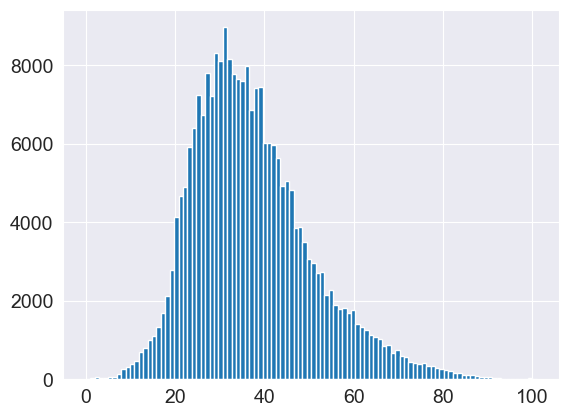

In [275]:
df['age'].hist(bins=102);

In [291]:
# # FOR PRESENTATION AND REPO USAGE ONLY
# fig, ax = plt.subplots()
# fig.set_alpha(1.0)
# text_color='black'

# # plt.rc('axes', titlesize=26)
# # plt.rc('axes', labelsize=22)
# # plt.rc('xtick', labelsize=18)
# # plt.rc('ytick', labelsize=18)

# plt.rc('axes', titlesize=20)
# plt.rc('axes', labelsize=18)
# plt.rc('xtick', labelsize=14)
# plt.rc('ytick', labelsize=14)

# plt.subplots_adjust(bottom=0.15, left=0.15)
# ax.hist(df['age'], bins=102)
# ax.tick_params(axis='both', colors=text_color)
# ax.set_title("Amount of Images by Age", c=text_color)
# ax.set_xlabel("Age", c=text_color)
# ax.set_ylabel("Images", c=text_color)
# fig.savefig('images/age_distribution_repo.png', transparent=False);

In [309]:
# # FOR PRESENTATION AND REPO USAGE ONLY
# fig, ax = plt.subplots()
# fig.set_alpha(1.0)
# text_color = 'black'
# # plt.rc('axes', titlesize=26)
# # plt.rc('axes', labelsize=22)
# # plt.rc('xtick', labelsize=18)
# # plt.rc('ytick', labelsize=18)

# plt.rc('axes', titlesize=20)
# plt.rc('axes', labelsize=18)
# plt.rc('xtick', labelsize=14)
# plt.rc('ytick', labelsize=14)

# plt.subplots_adjust(bottom=0.15, left=0.15)
# sns.histplot(data=df, x='age', hue='gender', bins=102, multiple='stack');
# ax.tick_params(axis='both', colors=text_color)
# ax.set_title("Amount of Images by Age", c=text_color)
# ax.set_xlabel("Age", c=text_color)
# ax.set_ylabel("Images", c=text_color)
# fig.savefig('images/ages_by_gender_repo.png', transparent=False);


Let's get an idea of how the data is distributed between genders.

In [182]:
df['gender'].value_counts()

M    141038
F    104166
Name: gender, dtype: int64

In [218]:
df.groupby('gender').mean()

,age
gender,
F,33.640785
M,39.794857


In [220]:
df.groupby('gender').median()

,age
gender,
F,32.0
M,38.0


In [219]:
df.groupby('gender').std()

,age
gender,
F,12.211085
M,13.915739


## Data Preparation

According to [PickFu.com](https://www.pickfu.com/demographic-segmentation), Marketing demographic age groups are typically: 18-24, 25-34, 35-44, 45-54, 55-64, and 65 and older

We'll split the ages into these groups using .apply and a function.

We're not interested in advertising to individuals under age 18, so we can drop those from our data set.

In [16]:
# function to group ages
def age_split(age):
    if age < 18:
        return 'X'
    if age in range(18,25):
        return 'A'
    if age in range(25,35):
        return 'B'
    if age in range(35,45):
        return 'C'
    if age in range(45,55):
        return 'D'
    if age in range(55,65):
        return 'E'
    else:
        return 'F'

In [17]:
df['age'] = df['age'].apply(age_split)

In [18]:
df.head()

,path,age,gender
0,sarasugarman/nm0837406_rm2246023424_1965-10-13...,C,F
1,fredwillard/nm0929609_rm3469383936_1939-9-18_2...,E,M
2,fredwillard/nm0929609_rm526752256_1939-9-18_20...,E,M
3,fredwillard/nm0929609_rm4210202880_1939-9-18_2...,E,M
4,fredwillard/nm0929609_rm275094016_1939-9-18_20...,E,M


In [19]:
df['age'].value_counts()

B    78027
C    65902
D    34742
A    30926
E    16371
F    10792
X     8444
Name: age, dtype: int64

In [20]:
# Dropping indiviudals under 18
df = df.drop(df.loc[df['age'] == 'X'].index)
df = df.reset_index(drop=True)

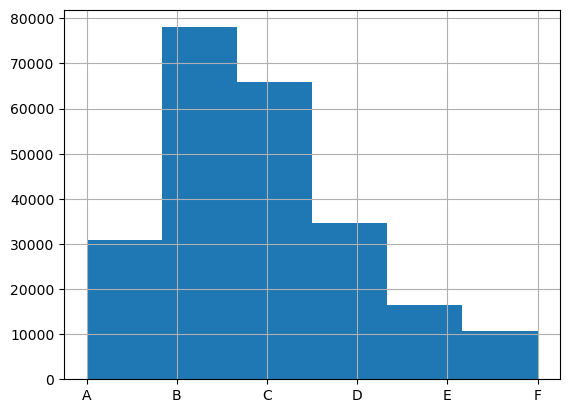

In [18]:
df['age'].sort_values().hist(bins=6);

In [310]:
# # FOR PRESENTATION AND REPO USAGE ONLY
# fig, ax = plt.subplots()
# fig.set_alpha(1.0)
# text_color = 'black'

# # plt.rc('axes', titlesize=26)
# # plt.rc('axes', labelsize=22)
# # plt.rc('xtick', labelsize=18)
# # plt.rc('ytick', labelsize=18)

# plt.rc('axes', titlesize=20)
# plt.rc('axes', labelsize=18)
# plt.rc('xtick', labelsize=14)
# plt.rc('ytick', labelsize=14)

# plt.subplots_adjust(bottom=0.15, left=0.17)
# ax.hist(df['age'].sort_values(), bins=6)
# ax.tick_params(axis='both', colors=text_color)
# ax.set_title("Amount of Images by Age", c=text_color)
# ax.set_xlabel("Age", c=text_color)
# ax.set_xticklabels(['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
# ax.set_ylabel("Images", c=text_color)
# fig.savefig('images/age_groups_repo.png', transparent=False);

We have a large class imbalance between our age groups, with group F (65+) having ~11k examples, whereas group B (25-34) has ~80k examples. This could cause problems later on during modeling, where our model could overfit to the Group B and underfit to Group F. Let's proceed as is and determine later on if we must address this, and if so how.

Let's now convert our age and gender targets into numerics to be used in the training process. For our age target, we'll create a one-hot encoded list of the age groups. The gender target will be a column of single binary values.

In [21]:
ohe = OneHotEncoder(sparse=False)
age = ohe.fit_transform(df[['age']]).tolist()
df['age'] = age
df['gender'] = df['gender'].str.get_dummies()['M']
df.head(10)

,path,age,gender
0,sarasugarman/nm0837406_rm2246023424_1965-10-13...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",0
1,fredwillard/nm0929609_rm3469383936_1939-9-18_2...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
2,fredwillard/nm0929609_rm526752256_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
3,fredwillard/nm0929609_rm4210202880_1939-9-18_2...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
4,fredwillard/nm0929609_rm275094016_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
5,fredwillard/nm0929609_rm509975040_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
6,fredwillard/nm0929609_rm924956672_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
7,fredwillard/nm0929609_rm102873088_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
8,fredwillard/nm0929609_rm119650304_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
9,fredwillard/nm0929609_rm3704002560_1939-9-18_2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1


Now that we have our data cleaned and classified, let's split it into file paths and targets.

In [22]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [23]:
len(df_train), len(df_test)

(189408, 47352)

### Utility Functions

We will need to use multiple Image Data Generators, so we can create a function that will enable these to be created more easily.

In order to increase the variety of images shown to the model we'll augment the images. There are various types of augmentation. Our images have already been cropped to contain 50%+ context, therefore we won't augment with translations or zooms. Instead, we can vary the brightness and rotation to introduce variance with regards to subject orientation as well as photo/lighting variation. Because we're augmenting training data, this function will need to create two separate flavors of generators. One will output the training generator which will produce augmented images for model training. The other generator will output unaugmented images for validation. It's important these two generators use the same random seed so we can ensure they contain no like elements.

In [24]:
def ImgGen(dataframe, img_size=(128,128), batch_size=32, brightness=[0.7, 1.3], vsplit=0.2, rrange=15, seed=2023, shuffle=True):
    """Function for the creation of Image Data Generators. 
    
    Parameters
    ----------
    dataframe: dataframe of images to be output by the generators
    img_size: desired output image size; default (128,128)
    batch_size: number of images to be returned by each call to the generator; default 32
    brightness: range of brightness for the images to be augmented by; default [0.7, 1.3]
    vsplit: percentage of images to be allocated to validation set; default 0.2
    rrange: range of rotation for augmented images; default 15
    seed: random seed; default 2023
    shuffle: boolean determining whether to shuffle the images; default True
    """

    dir = os.getcwd() + '\\B3FD\\'

    train_datagen = ImageDataGenerator(validation_split=vsplit, rotation_range=rrange, fill_mode='nearest',
                                       brightness_range=brightness, rescale=1./255)
    
    val_datagen = ImageDataGenerator(validation_split=vsplit, rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(dataframe, dir, x_col='path', y_col=['age', 'gender'], class_mode='multi_output', batch_size=batch_size,
                                                  target_size=img_size, subset='training', shuffle=shuffle, seed=seed)
    
    val_gen = val_datagen.flow_from_dataframe(dataframe, dir, x_col='path', y_col=['age', 'gender'], class_mode='multi_output', batch_size=batch_size,
                                                  target_size=img_size, subset='validation', shuffle=shuffle, seed=seed)
    

    return train_gen, val_gen

We'll also create a function to plot the results of our model training

In [221]:
# There exists much more pythonic ways to accomplish this,
# however for the sake of easy I created this function in a much more ugly way
def plot_history(history):
    if 'age_recall' in history.history.keys():
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,7.5))
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7.5))

    ax1.set_title('Loss')
    sns.lineplot(x=history.epoch, y=history.history['loss'], ax=ax1, label='Train Loss')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], ax=ax1, label='Val Loss')

    ax2.set_title('Loss by Target')
    sns.lineplot(x=history.epoch, y=history.history['gender_loss'], ax=ax2, label='Train Loss: Gender')
    sns.lineplot(x=history.epoch, y=history.history['val_gender_loss'], ax=ax2, label='Val Loss: Gender')
    sns.lineplot(x=history.epoch, y=history.history['age_loss'], ax=ax2, label='Train Loss: Age')
    sns.lineplot(x=history.epoch, y=history.history['val_age_loss'], ax=ax2, label='Val Loss: Age')

    ax3.set_title('Accuracy')
    ax3.set_ylim([0, None])
    sns.lineplot(x=history.epoch, y=history.history['gender_accuracy'], ax=ax3, label='Train Accuracy: Gender')
    sns.lineplot(x=history.epoch, y=history.history['val_gender_accuracy'], ax=ax3, label='Val Accuracy: Gender')
    sns.lineplot(x=history.epoch, y=history.history['age_accuracy'], ax=ax3, label='Train Accuracy: Age')
    sns.lineplot(x=history.epoch, y=history.history['val_age_accuracy'], ax=ax3, label='Val Accuracy: Age')

    try:
        ax4.set_title('Precision')
        ax4.set_ylim([0, None])
        sns.lineplot(x=history.epoch, y=history.history['gender_precision_1'], ax=ax4, label='Train Precision: Gender')
        sns.lineplot(x=history.epoch, y=history.history['val_gender_precision_1'], ax=ax4, label='Val Precision: Gender')
        sns.lineplot(x=history.epoch, y=history.history['age_precision'], ax=ax4, label='Train Precision: Age')
        sns.lineplot(x=history.epoch, y=history.history['val_age_precision'], ax=ax4, label='Val Precision: Age')

        ax5.set_title('Recall')
        ax5.set_ylim([0, None])
        sns.lineplot(x=history.epoch, y=history.history['gender_recall_1'], ax=ax5, label='Train Recall: Gender')
        sns.lineplot(x=history.epoch, y=history.history['val_gender_recall_1'], ax=ax5, label='Val Recall: Gender')
        sns.lineplot(x=history.epoch, y=history.history['age_recall'], ax=ax5, label='Train Recall: Age')
        sns.lineplot(x=history.epoch, y=history.history['val_age_recall'], ax=ax5, label='Val Recall: Age')

    except:
        pass



Now we can create a function to display a sample of the output of our train generator to ensure everything looks correct

In [91]:
def gen_sample(generator):
    """Function which takes in an image generator and displays a sample of 9 images"""
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    # Create list for labeling images
    age_groups = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    genders = ['Female', 'Male']
    img, label = generator.next()
    for i, ax in enumerate(axes.flat):
        title = f'Age: {age_groups[label[0][i].argmax()]}, Gender: {genders[label[1][i]]}'
        ax.imshow(img[i])
        ax.set(title=f"{title}")
        ax.axis('off')
    fig.suptitle('Examples of Generated Images', fontsize=30)
    plt.tight_layout()
    fig.savefig('images/image_samples.png', transparent=False);
    plt.show();

### Functions for creating models

First we'll create our convolutional block. This is inspired by the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by [He](https://scholar.google.com/citations?user=DhtAFkwAAAAJ&hl=en) et al. The major insight of this paper is that creating "residual connections" also known as "skip connections" drastically increases training performance in models with many layers. Using an Addition layer we can create a pathway for the gradient to flow around our convolutional block, as well as through it. This helps remedy the issue known as ["vanishing gradient"](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) often seen in deep learning models with many layers.

In [96]:
def conv_block(x, filter):
    # copying input x
    x_resid = x

    # conv layer 1
    x = Conv2D(filter, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # conv layer 2
    x = Conv2D(filter, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # creating residual connection
    x_resid = Conv2D(filter, kernel_size=3, strides=(2,2), padding='same')(x_resid)
    x = Add()([x, x_resid])
    x = Activation('relu')(x)

    return x 

Next we can create the primary model function. We have a multi-target problem (age and gender), so our model will need to have two output layers. This can easily be achieved by routing our final layer to both output layers. We have six age classes, so we'll create one output with 6 nodes and a softmax activation function. For the gender output we can simply use 1 node with a sigmoid activation function. Doing it this way will enable us to compare the models age output to the age column of the dataframe, which contains a one-hot encoded list of age groups. The second output can then be compared to the boolean gender column.

In [97]:
def make_model(shape=(64,64,3), filter_size=128, conv_loops=4):
    
    # first layer and pooling
    input_layer = keras.Input(shape=shape, name='input_layer')
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)

    # cycle through convolutional blocks
    for i in range(conv_loops):
        if i > 0:
            filter_size *= 2
        x = conv_block(x, filter_size)
    
    # penultimate layer
    x = AveragePooling2D((2,2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    # output layers
    age_output = Dense(6, activation='softmax', name='age')(x)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)

    model = keras.Model(inputs=input_layer, outputs=[age_output, gender_output])
    return model

## Baseline Model

To have a baseline to gauge the efficacy of our model, we can consider each of our two targets separately. In particular, let's guess the most common class of each target. Using this we can contextualize the accuracy scores achieved by our models. 

##### Gender Baseline:
We have 236,760 total images, of which 141,038 are classified as male, with the remaining classified as female. Therefore, by classifying as male for every image, we would achieve an accuracy of  
  
$Baseline Gender Accuracy: \frac{141,038}{236,760} = 0.595$, or $59.5\%$

##### Age Baseline:
Similarly, of our 236,760 total images, our most common class is 25-34, comprising 78,027 of our images. Thus, classifying every image as 25-34, we would achieve an accuracy of  
  
$Baseline Age Accuracy: \frac{78,027}{236,760} = 0.329$, or $32.9\%$

Going forward these will be our accuracy scores to beat.

## Modeling

### Model 0

For our first model let's use small images and a small network to start off with. This will hopefully give us insight into improvements we can make in subsequent models. It can be tricky to achieve success with a multi-target output, so this first model will be an important step to identifying weaknesses to be remedied.

In [25]:
train_gen0, val_gen0 = ImgGen(df_train, img_size=(32,32))

Found 151527 validated image filenames.
Found 37881 validated image filenames.


In [8]:
slash  = '\\'
imdb_file = pd.read_csv(f'B3FD_metadata{slash}B3FD-IMDB_age_gender.csv', delimiter=' ')
imdb_file.head()

,path,age,gender
0,sarasugarman/nm0837406_rm2246023424_1965-10-13...,39,F
1,fredwillard/nm0929609_rm3469383936_1939-9-18_2...,64,M
2,fredwillard/nm0929609_rm526752256_1939-9-18_20...,64,M
3,fredwillard/nm0929609_rm4210202880_1939-9-18_2...,64,M
4,fredwillard/nm0929609_rm275094016_1939-9-18_20...,64,M


In [89]:
# Checking that our train and val generator function is working as expected
# (that there are no common files within train and val sets)
gen_check = train_gen0.filenames + val_gen0.filenames
len(gen_check) == len(set(gen_check))

True

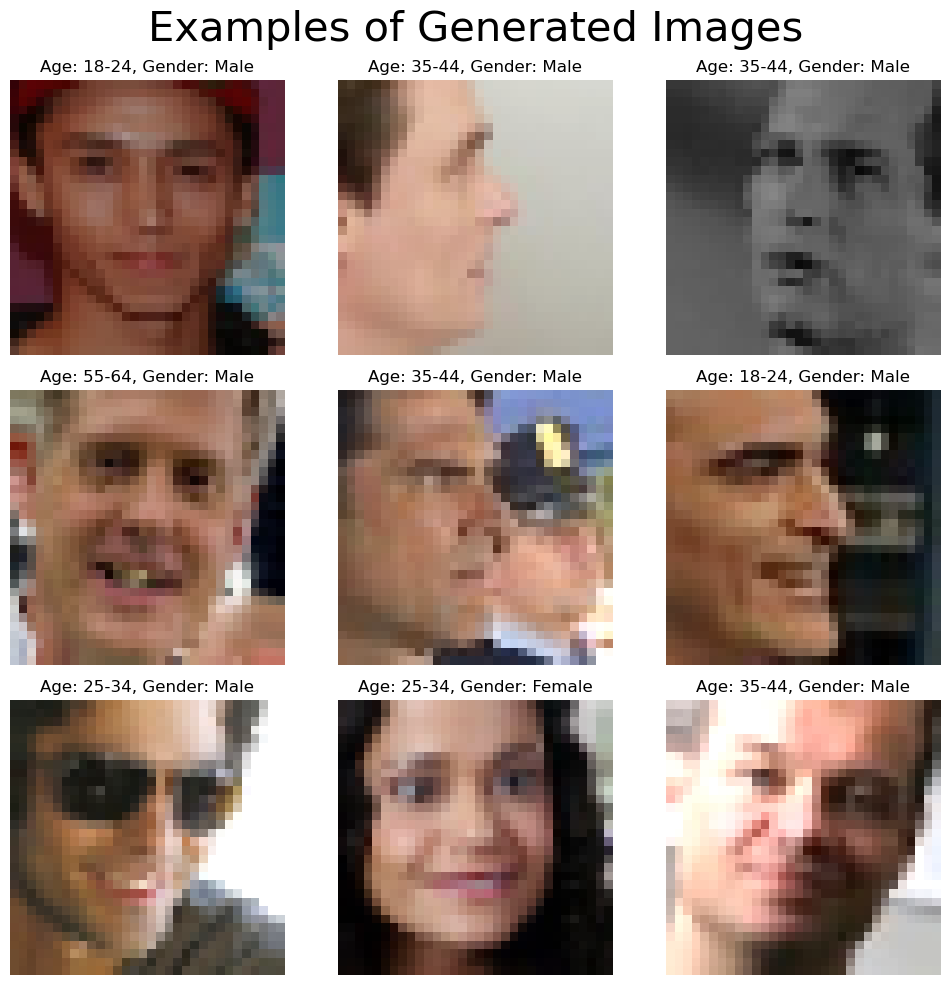

In [92]:
gen_sample(train_gen0)

In [98]:
model0 = make_model(shape=(32,32,3), filter_size=64, conv_loops=2)

In [99]:
model0.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 32, 32, 128)  3584        ['input_layer[0][0]']            
                                                                                                  
 batch_normalization_19 (BatchN  (None, 32, 32, 128)  512        ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_19[0]

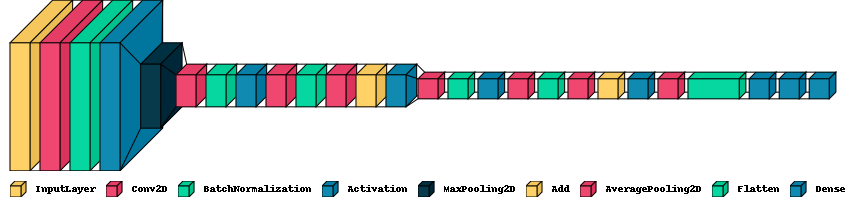

In [100]:
visualkeras.layered_view(model0, legend=True)

In [101]:
model0.compile(optimizer='adam', loss=[CategoricalCrossentropy(), BinaryCrossentropy()], loss_weights=[50,1], metrics=['accuracy'])

In [102]:
results0 = model0.fit(train_gen0, epochs=5, validation_data=val_gen0, validation_steps=100//train_gen0.batch_size)

Epoch 1/5
4736/4736 [==============================] - 278s 58ms/step - loss: 72.4813 - age_loss: 1.4399 - gender_loss: 0.4858 - age_accuracy: 0.3808 - gender_accuracy: 0.7619 - val_loss: 79.2125 - val_age_loss: 1.5775 - val_gender_loss: 0.3399 - val_age_accuracy: 0.3229 - val_gender_accuracy: 0.8750
Epoch 2/5
4736/4736 [==============================] - 257s 54ms/step - loss: 67.4412 - age_loss: 1.3419 - gender_loss: 0.3472 - age_accuracy: 0.4152 - gender_accuracy: 0.8512 - val_loss: 74.5152 - val_age_loss: 1.4828 - val_gender_loss: 0.3731 - val_age_accuracy: 0.4271 - val_gender_accuracy: 0.8333
Epoch 3/5
4736/4736 [==============================] - 257s 54ms/step - loss: 65.3290 - age_loss: 1.3006 - gender_loss: 0.2995 - age_accuracy: 0.4321 - gender_accuracy: 0.8759 - val_loss: 76.1816 - val_age_loss: 1.5183 - val_gender_loss: 0.2665 - val_age_accuracy: 0.3021 - val_gender_accuracy: 0.9271
Epoch 4/5
4736/4736 [==============================] - 257s 54ms/step - loss: 64.0953 - age_lo

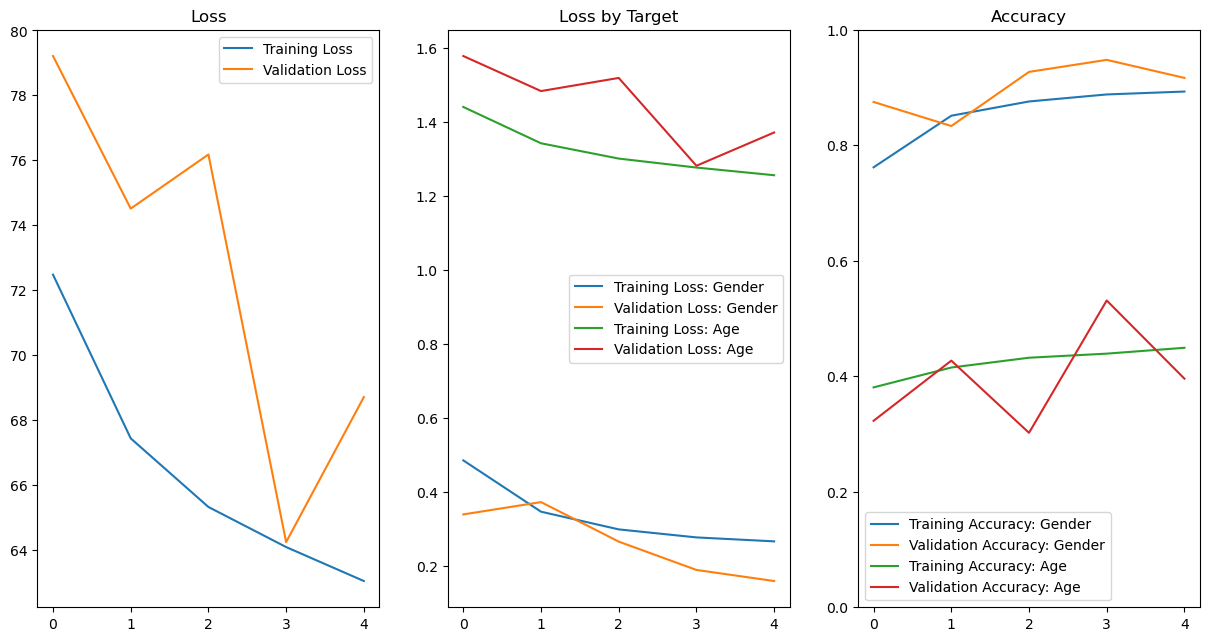

In [103]:
plot_history(results0)

This compiled, trained, and validated correctly. The results were poor, however that was to be expected. Let's now increase the image size, the depth of the network, and the total number of epochs.

### Model 1

For this first attempt at an accurate model, we'll use images of 64x64 shape, use a filter size of 128, loop through the convolutional block 4 times, and bump up to 50 epochs. We purposely set these as the default when creating the `make_model` function.

In [104]:
train_gen1, val_gen1 = ImgGen(df_train, img_size=(64,64))

Found 151527 validated image filenames.
Found 37881 validated image filenames.


In [105]:
test_gen1, null_gen = ImgGen(df_test, img_size=(64,64))

Found 37882 validated image filenames.
Found 9470 validated image filenames.


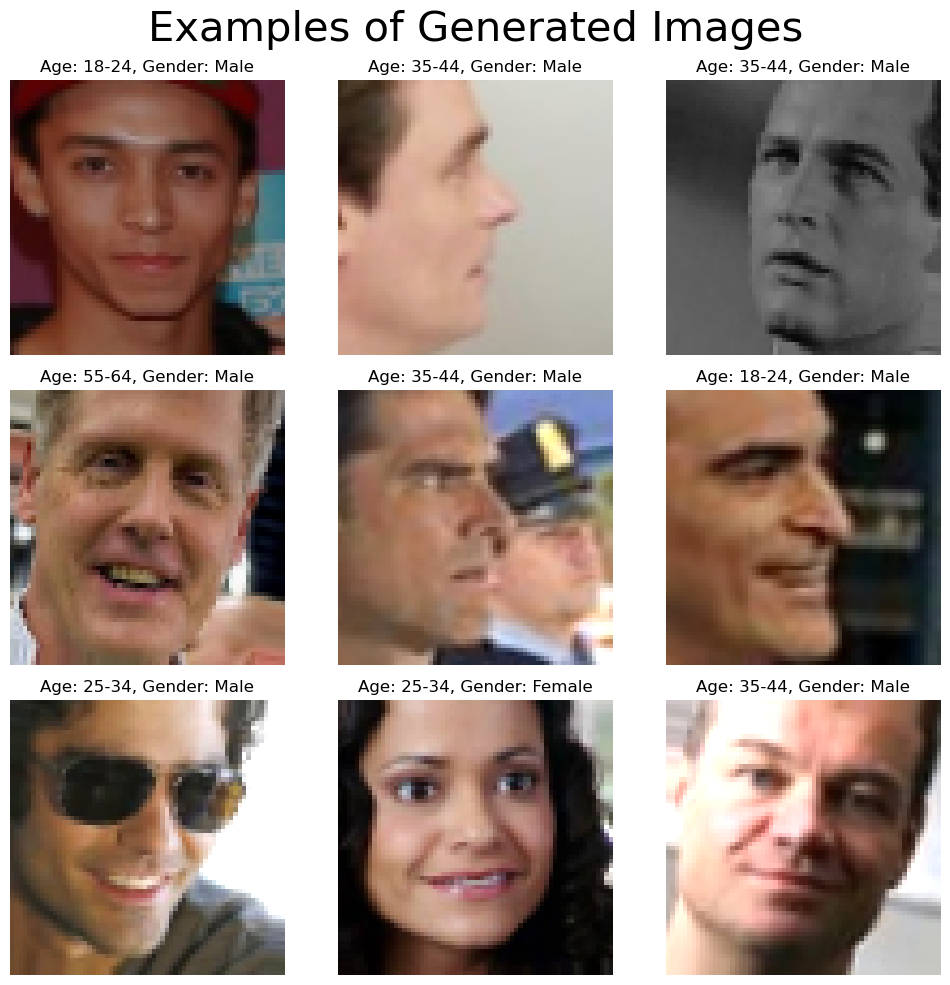

In [106]:
gen_sample(train_gen1)

In [31]:
model1 = make_model()

In [35]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 128)  3584        ['input_layer[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 64, 128)  0           ['batch_normalization[0][0]']

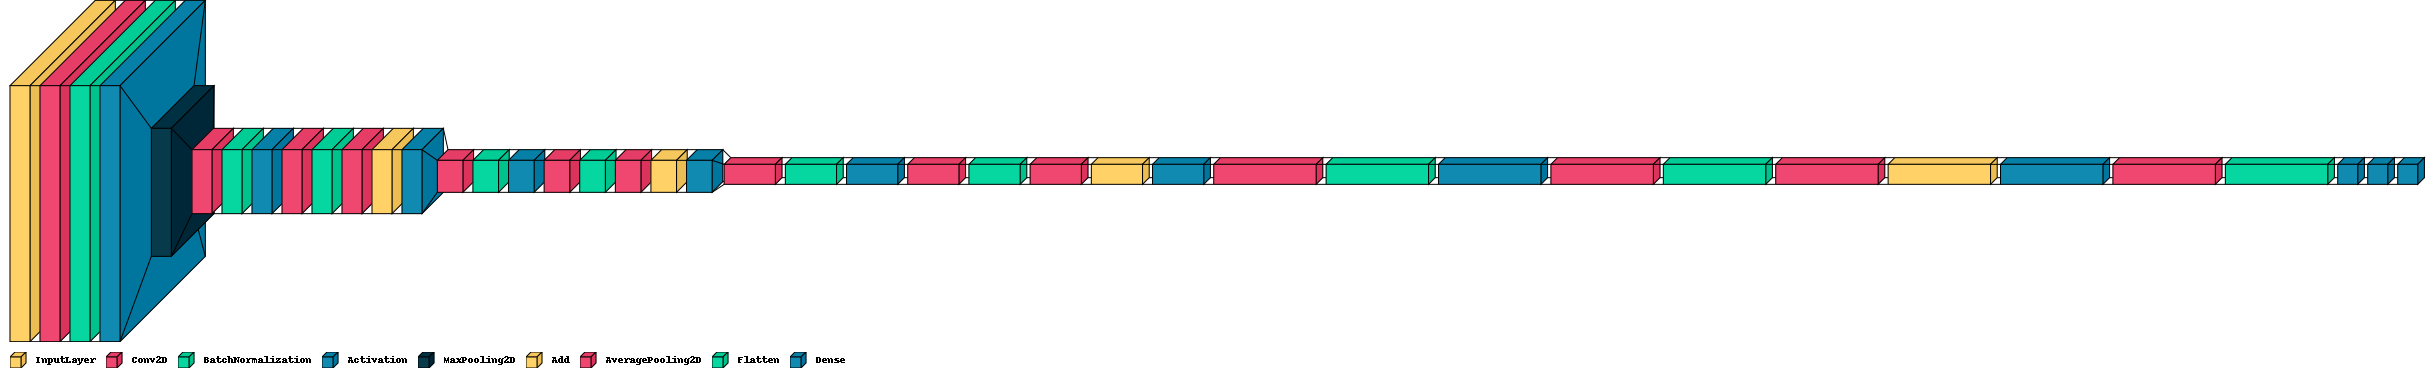

In [36]:
visualkeras.layered_view(model1, legend=True)

In [37]:
model1.compile(optimizer='adam', loss=[CategoricalCrossentropy(), BinaryCrossentropy()], loss_weights=[50,1], metrics=['accuracy'])

In [400]:
results1 = model1.fit(train_gen1, epochs=50, validation_data=val_gen1, validation_steps=100//train_gen1.batch_size)

Epoch 1/50
4736/4736 [==============================] - 4503s 950ms/step - loss: 72.9302 - age_loss: 1.4472 - gender_loss: 0.5728 - age_accuracy: 0.3776 - gender_accuracy: 0.6971 - val_loss: 70.8872 - val_age_loss: 1.4054 - val_gender_loss: 0.6172 - val_age_accuracy: 0.4062 - val_gender_accuracy: 0.6771
Epoch 2/50
4736/4736 [==============================] - 4497s 950ms/step - loss: 66.1480 - age_loss: 1.3120 - gender_loss: 0.5498 - age_accuracy: 0.4261 - gender_accuracy: 0.7078 - val_loss: 68.9408 - val_age_loss: 1.3682 - val_gender_loss: 0.5286 - val_age_accuracy: 0.4896 - val_gender_accuracy: 0.7292
Epoch 3/50
4736/4736 [==============================] - 4444s 938ms/step - loss: 63.5924 - age_loss: 1.2609 - gender_loss: 0.5460 - age_accuracy: 0.4457 - gender_accuracy: 0.7090 - val_loss: 63.3470 - val_age_loss: 1.2548 - val_gender_loss: 0.6079 - val_age_accuracy: 0.4271 - val_gender_accuracy: 0.6667
Epoch 4/50
4736/4736 [==============================] - 4584s 968ms/step - loss: 61.3

In [ ]:
plot_history(results1)

![Model 1 Results](images/model1results.png)

In [446]:
model1.save_weights('models/model1_weights')

In [33]:
model1.load_weights('models/model1_weights')

In [39]:
model1.save('models/model1')

INFO:tensorflow:Assets written to: models/model1\assets


INFO:tensorflow:Assets written to: models/model1\assets


#### Analysis of Model 1 Results

We suspect the large fluctuations in validation loss and accuracy is due to the very small subset of validation data fed to the model during validation. For the next model we can increase this to hopefully see smoother validaton curves.

As evidenced by the increasing gap between the Training Age Loss and the Validation Age Loss, our model is greatly overfitting. There are several ways this can be addressed:
- Increase complexity of input data by increasing image size from (64,64) to (128,128)
- Reduce Gender Loss weight. (Currently at 50:1)
- Add Dropout or other forms of regularization

The gap in accuracy between our targets (age and gender) can possibly be explained as follows:
- Gender is in some ways a much more macroscopic trait. It often manifests itself in larger features such as hair length, earrings or necklaces, physical facial sturcture, whereas,
- Age is often times much more granular, manifesting in wrinkles in the forehead, around the eyes and mouth, as well as in some instances gray hair

Therefore, we suspect that the quite pixelated images at 64x64 resolution are lacking the more granular information required for accurate age classification.

Going forward, we will increase the image size to (128,128), reduce Gender Loss weight to 25, as well as add Dropout.

### Model 2

Reworking this model will require modifying the structure of our model definition functions. In particular, adding dropout, as well as altering the shape of input layers. In addition, modifying the dimension of input images will require new image generators. We'll also increase the size of the validation set, primarily to decrease training times.

In [48]:
train_gen2, val_gen2 = ImgGen(df_train, vsplit=0.4, batch_size=128)

Found 113645 validated image filenames.
Found 75763 validated image filenames.


In [84]:
test_gen2, null_gen = ImgGen(df_test, batch_size=128, vsplit=0, brightness=None, rrange=0, shuffle=False)

Found 47352 validated image filenames.
Found 0 validated image filenames.


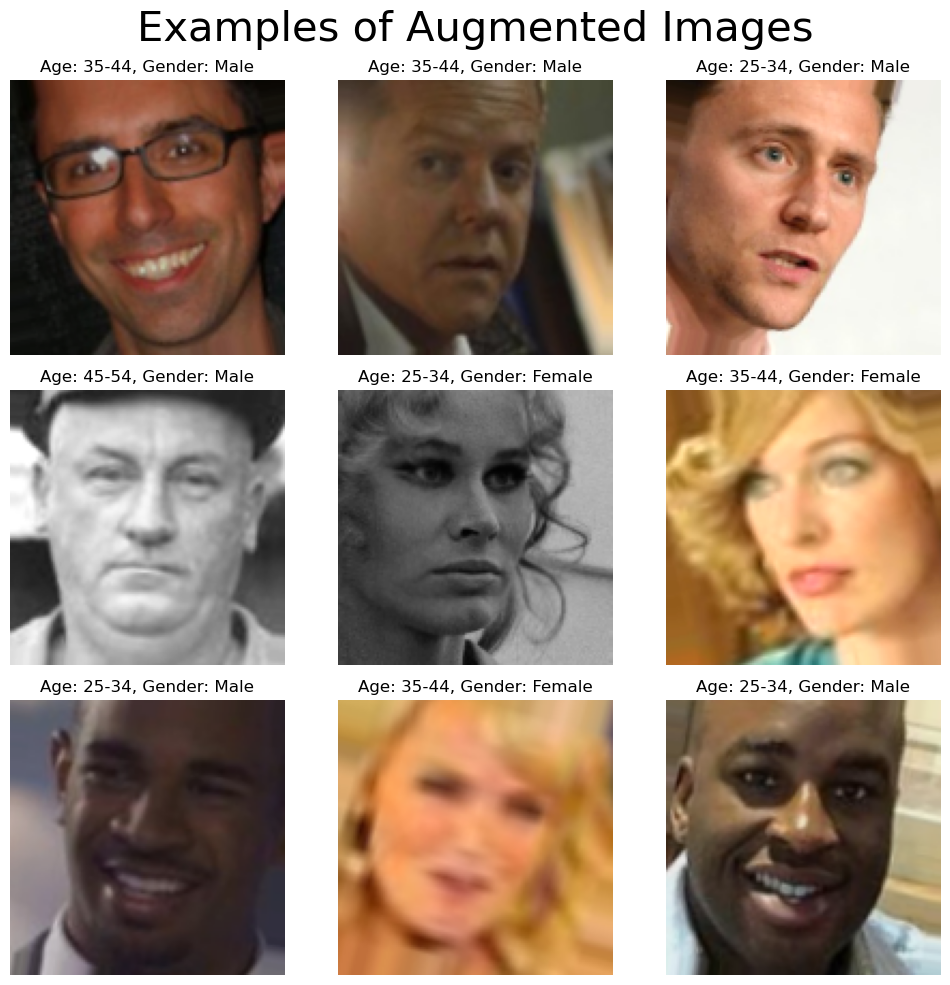

In [79]:
gen_sample(train_gen2)

Now let's reinstantiate the model with the aforementioned modifications.

The [original paper proposing dropout](https://arxiv.org/pdf/1207.0580.pdf) only applied it between Dense layers, however [later research](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf) has shown some benefit to including a small amount of dropout between convolutional layers as well. Thus we will apply some dropout in both of these instances.

Unfortunately we cannot use the previously created function to generate this model because we will need to change the structure itself. We'll forego creating a new function, as ideally this will only necessitate a single usage.

In [52]:
def conv_block(x, filter):
    # copying input x
    x_resid = x

    # conv layer 1
    x = Conv2D(filter, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x) # Dropout layer

    # conv layer 2
    x = Conv2D(filter, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # creating residual connection
    x_resid = Conv2D(filter, kernel_size=3, strides=(2,2), padding='same')(x_resid)
    x = Add()([x, x_resid])
    x = Activation('relu')(x)

    return x 

In [53]:
def make_model(shape=(128,128,3)):
    filter_size = 128
    
    # first layer and pooling
    input_layer = keras.Input(shape=shape, name='input_layer')
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)

    # cycle through layer blocks
    for i in range(5):
        if i > 0:
            filter_size *= 2
        x = conv_block(x, filter_size)
    
    # penultimate layer
    x = AveragePooling2D((2,2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # output layers
    age_output = Dense(6, activation='softmax', name='age')(x)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)

    model = keras.Model(inputs=input_layer, outputs=[age_output, gender_output])
    return model


In [54]:
model2 = make_model()

In [55]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 12  3584        ['input_layer[0][0]']            
                                8)                                                                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 128, 12  512        ['conv2d_13[0][0]']              
 rmalization)                   8)                                                          

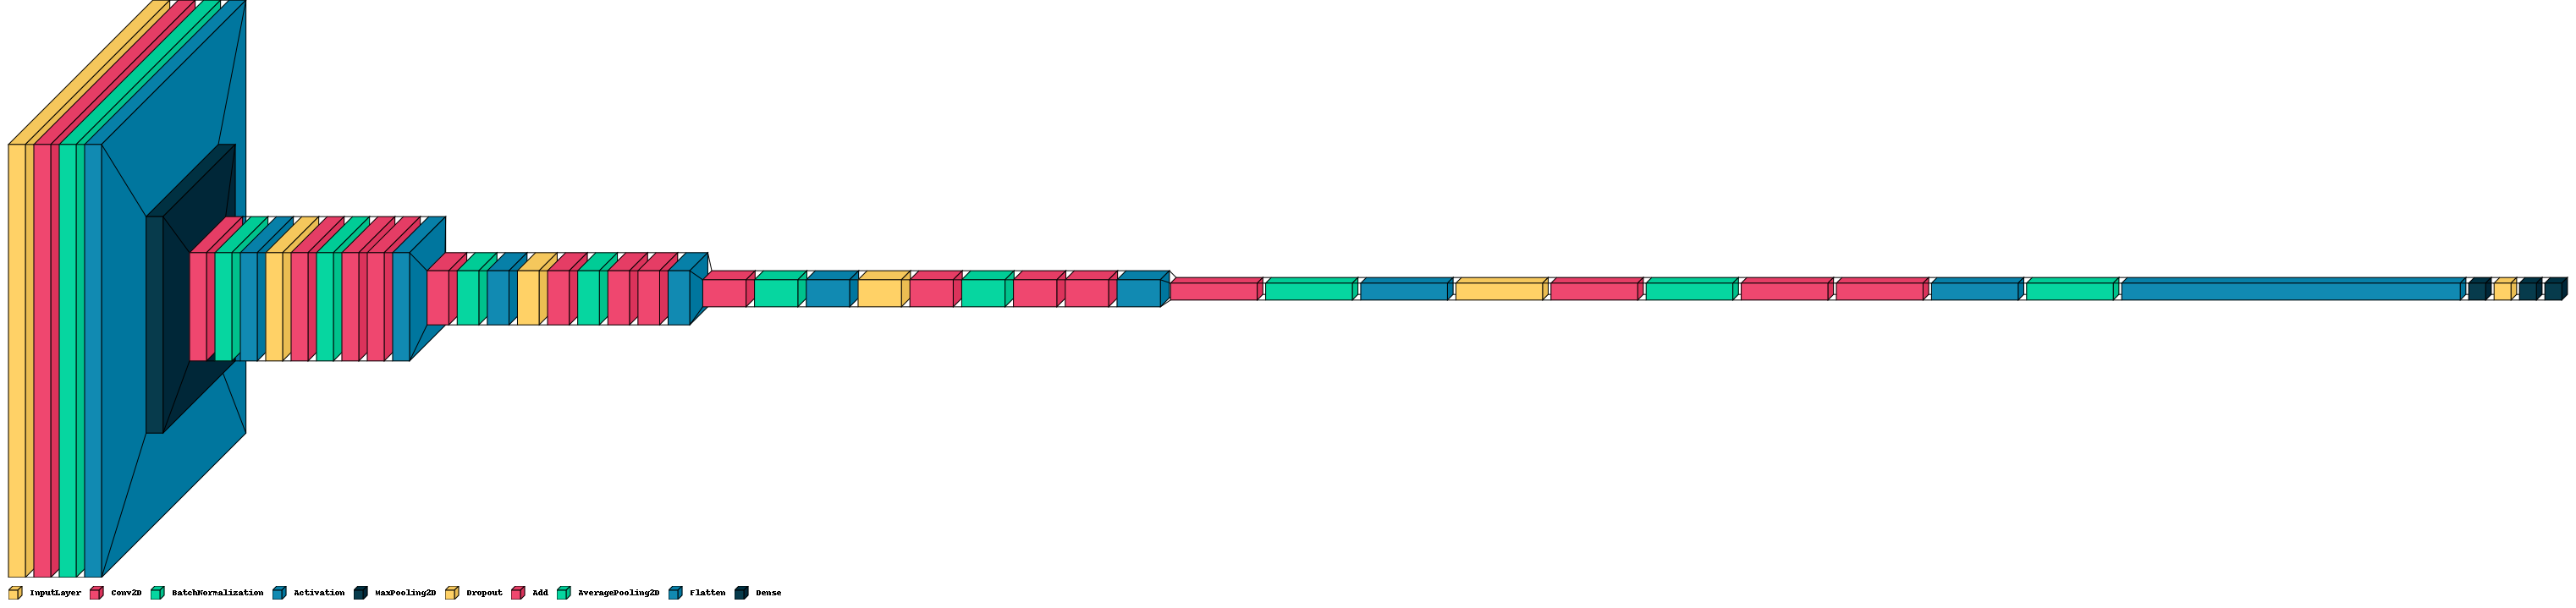

In [312]:
visualkeras.layered_view(model2, legend=True)

In [56]:
model2.compile(optimizer='adam', loss=[CategoricalCrossentropy(), BinaryCrossentropy()], loss_weights=[25,1], metrics=['accuracy', 'Recall', 'Precision'])

In [81]:
results2 = model2.fit(train_gen2, epochs=20, validation_data=val_gen2, validation_steps=100)

Epoch 1/20
888/888 [==============================] - 7079s 8s/step - loss: 40.4000 - age_loss: 1.5890 - gender_loss: 0.6742 - age_accuracy: 0.3304 - age_recall: 9.6793e-04 - age_precision: 0.4029 - gender_accuracy: 0.5873 - gender_recall_1: 0.9631 - gender_precision_1: 0.5881 - val_loss: 40.2651 - val_age_loss: 1.5832 - val_gender_loss: 0.6863 - val_age_accuracy: 0.3319 - val_age_recall: 3.1250e-04 - val_age_precision: 0.4000 - val_gender_accuracy: 0.5900 - val_gender_recall_1: 0.6113 - val_gender_precision_1: 0.6653
Epoch 2/20
888/888 [==============================] - 6620s 7s/step - loss: 38.6479 - age_loss: 1.5212 - gender_loss: 0.6187 - age_accuracy: 0.3481 - age_recall: 0.0129 - age_precision: 0.4796 - gender_accuracy: 0.6588 - gender_recall_1: 0.8266 - gender_precision_1: 0.6659 - val_loss: 38.2697 - val_age_loss: 1.5066 - val_gender_loss: 0.6040 - val_age_accuracy: 0.3545 - val_age_recall: 2.3437e-04 - val_age_precision: 0.6000 - val_gender_accuracy: 0.6704 - val_gender_recall

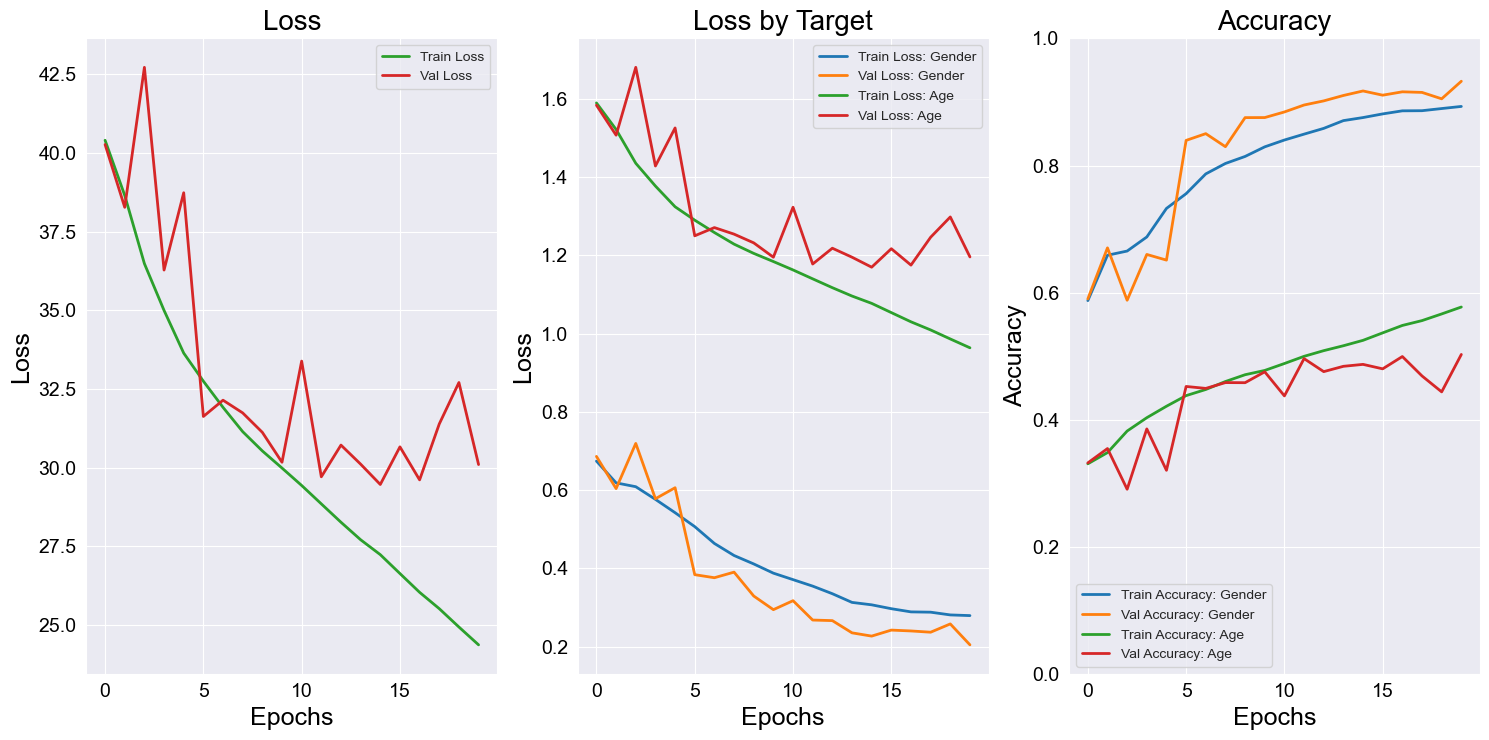

In [311]:
# # THIS IS ONLY TO BE USED FOR PRESENTATION AND REPO GRAPHS

# history = results2
# width = 2
# text_color = 'black'
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7.5))

# # plt.rc('axes', titlesize=26)
# # plt.rc('axes', labelsize=22)
# # plt.rc('xtick', labelsize=18)
# # plt.rc('ytick', labelsize=18)

# plt.rc('axes', titlesize=20)
# plt.rc('axes', labelsize=18)
# plt.rc('xtick', labelsize=14)
# plt.rc('ytick', labelsize=14)

# ax1.set_title('Loss', c=text_color)
# ax1.set_xlabel("Epochs", c=text_color)
# ax1.set_ylabel("Loss", c=text_color)
# ax1.tick_params(axis='both', colors=text_color)
# sns.lineplot(x=history.epoch, y=history.history['loss'], ax=ax1, label='Train Loss', linewidth=width, color='#2ca02c')
# sns.lineplot(x=history.epoch, y=history.history['val_loss'], ax=ax1, label='Val Loss', linewidth=width, color='#d62728')

# ax2.set_title('Loss by Target', c=text_color)
# ax2.set_xlabel("Epochs", c=text_color)
# ax2.set_ylabel("Loss", c=text_color)
# ax2.tick_params(axis='both', colors=text_color)
# sns.lineplot(x=history.epoch, y=history.history['gender_loss'], ax=ax2, label='Train Loss: Gender', linewidth=width)
# sns.lineplot(x=history.epoch, y=history.history['val_gender_loss'], ax=ax2, label='Val Loss: Gender', linewidth=width)
# sns.lineplot(x=history.epoch, y=history.history['age_loss'], ax=ax2, label='Train Loss: Age', linewidth=width)
# sns.lineplot(x=history.epoch, y=history.history['val_age_loss'], ax=ax2, label='Val Loss: Age', linewidth=width)

# ax3.set_title('Accuracy', c=text_color)
# ax3.set_xlabel("Epochs", c=text_color)
# ax3.set_ylabel("Accuracy", c=text_color)
# ax3.tick_params(axis='both', colors=text_color)
# ax3.set_ylim([0, None])
# sns.lineplot(x=history.epoch, y=history.history['gender_accuracy'], ax=ax3, label='Train Accuracy: Gender', linewidth=width)
# sns.lineplot(x=history.epoch, y=history.history['val_gender_accuracy'], ax=ax3, label='Val Accuracy: Gender', linewidth=width)
# sns.lineplot(x=history.epoch, y=history.history['age_accuracy'], ax=ax3, label='Train Accuracy: Age', linewidth=width)
# sns.lineplot(x=history.epoch, y=history.history['val_age_accuracy'], ax=ax3, label='Val Accuracy: Age', linewidth=width)

# plt.subplots_adjust(bottom=0.15, left=0.05)
# plt.tight_layout()

# fig.savefig('images/results_repo.png', transparent=False);

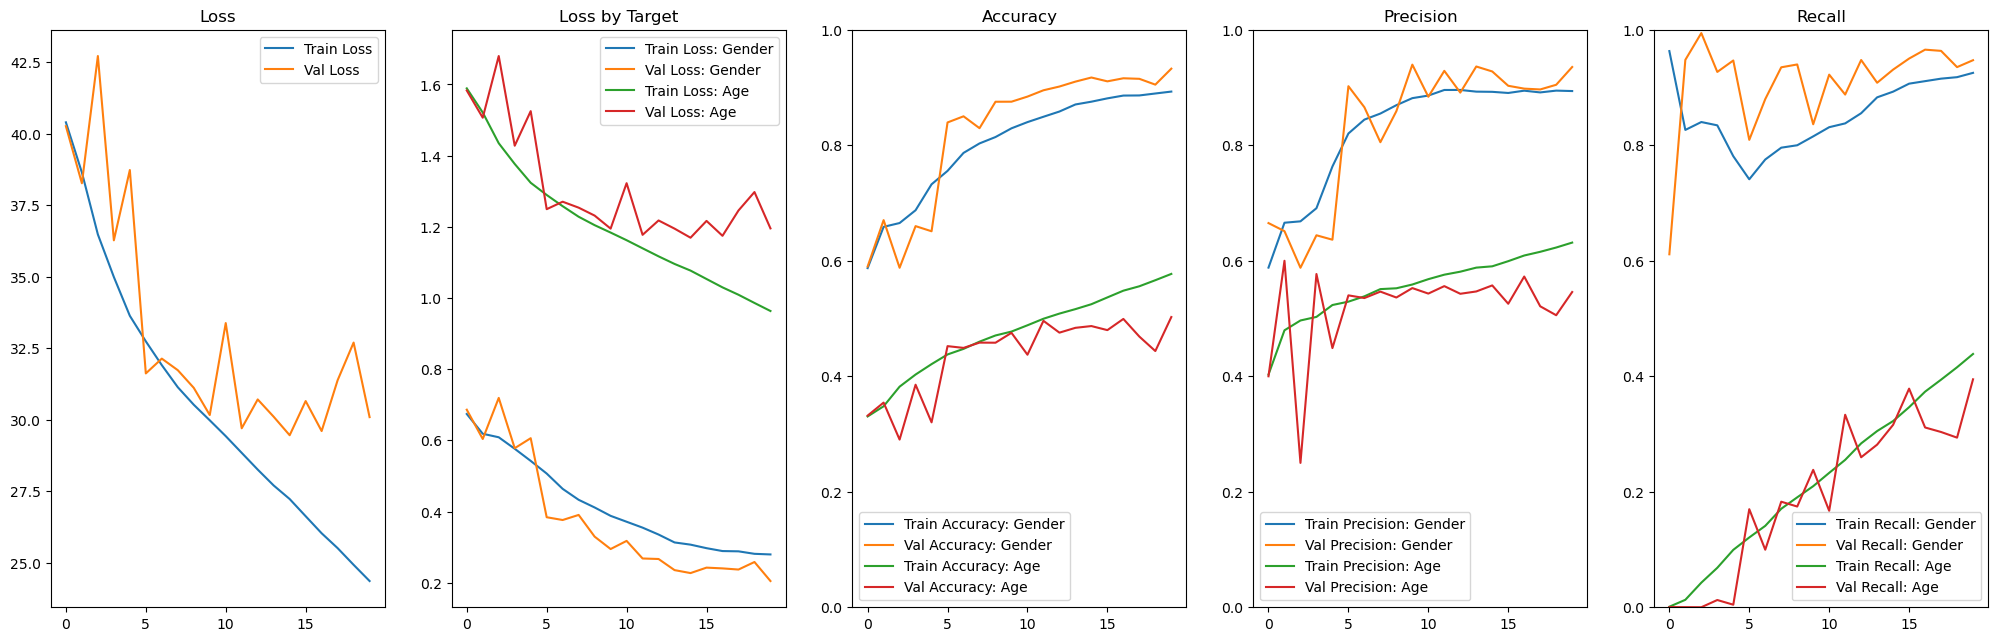

In [117]:
plot_history(results2)

In [87]:
model2.save_weights('models/model2_weights')

In [86]:
model2.save('models/model2')

INFO:tensorflow:Assets written to: models/model2\assets


INFO:tensorflow:Assets written to: models/model2\assets


In [107]:
model2.save('models/model2a', include_optimizer=False)

INFO:tensorflow:Assets written to: models/model2a\assets


INFO:tensorflow:Assets written to: models/model2a\assets


### Analysis of Model 2 Results

We're overfitting our age target to a much lesser extent. However, our validation accuracy does seem to have begun to diverge from our training accuracy. It would require more training epochs to know for sure. Our losses have not yet plateaued. Given more time, further training would likely serve to increase model accuracy. 

It also seems possible that weighting our gender target so much more highly than our age target has caused the gender target to begin to overfit. For next steps we can try lowering this some more to hopefully achieve better results.

Although for this use case the most important metric is accuracy, we have included Precision and Recall scores in order to garner more granular data regarding when our age prediction is and isn't correct. This information can hopefully inform further iterations of the model.

## Evaluation

In [38]:
model1.evaluate(test_gen1)

1480/1480 [==============================] - 154s 103ms/step - loss: 88.2967 - age_loss: 1.7620 - gender_loss: 0.1959 - age_accuracy: 0.5062 - gender_accuracy: 0.9328


[88.29667663574219,
 1.7620130777359009,
 0.19592343270778656,
 0.5062299370765686,
 0.9328433871269226]

In [85]:
model2.evaluate(test_gen2)

370/370 [==============================] - 422s 1s/step - loss: 30.1746 - age_loss: 1.1986 - gender_loss: 0.2088 - age_accuracy: 0.5047 - age_recall: 0.3962 - age_precision: 0.5495 - gender_accuracy: 0.9293 - gender_recall_1: 0.9450 - gender_precision_1: 0.9351


[30.174596786499023,
 1.1986315250396729,
 0.20881454646587372,
 0.5046671628952026,
 0.39618179202079773,
 0.5495181679725647,
 0.9292743802070618,
 0.9449888467788696,
 0.9350515007972717]

Due to time constraints we were unable to train until our lose plateaued. That said, on unseen data, we achieved a gender accuracy of 93%, and an age accuracy of 50%. These metrics are much better than our baseline models 59% and 39% respectively. With further training these scores can yet be improved. 

It seems as though our validation accuracy may have begun to diverge from our training accuracy. It's also possible that including gender loss weights to our optimizer may have caused the model to begin to overfit the gender target. As a preview to next steps, this is something we can iterate on. 

## Conclusion
All in all, we gathered and prepared a massive dataset, built functions for analysis and model imputation, and build multiple very large and complex multi-target deep learning models capable of reasonably accurate classification of images. This model and its progeny may well serve to inform marketing decisions for retailers in the near future. I am eager to implement the next steps outlined in this projects readme and presentation.